# Surface QUantitatIve pRecipitation Estimation (SQUIRE) for BNF

## Imports

In [1]:
import pyart
import matplotlib.pyplot as plt
import numpy as np
import glob
import act
from pathlib import Path


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
cmac_files = sorted(glob.glob("data/cmac/*"))
cmac_files

['data/cmac/bnfcsapr2cmacS3.c1.20250305.030006.nc']

## Load Data into Py-ART and Plot

In [3]:
radar = pyart.io.read(cmac_files[0])

(-100.0, 100.0)

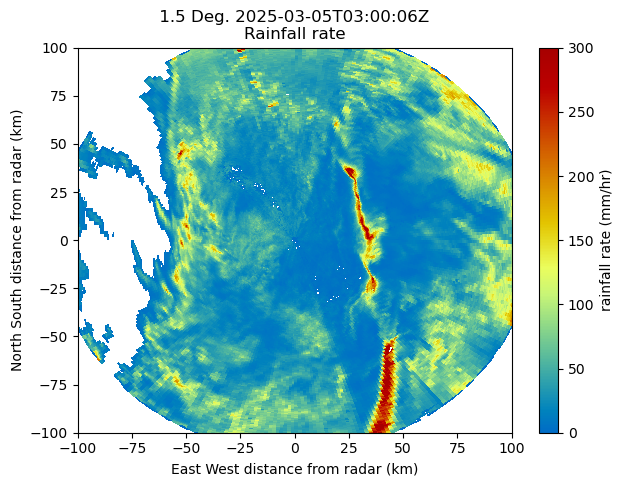

In [4]:
display = pyart.graph.RadarDisplay(radar)
fig = plt.figure(figsize=[7, 5])
ax = fig.add_subplot(111)
display.plot('rain_rate_A',
            0,
             vmin=0,
             vmax=300,
             cmap='HomeyerRainbow')
plt.xlim(-100, 100)
plt.ylim(-100, 100)

## Calculate the Rain Rate Using Z(R)
We have a rain rate using attenuation, but we also need to calculate the rain rate using an established Z(R) relationship. We will only apply this when Z < 35 dBZ.

In [8]:
def reflectivity_rain(radar, refl="reflectivity", alpha=0.0376, beta=0.6112):
    """
    Function to calculate rainfall rates from radar reflectivity factor

    Inputs
    ------
    radar : Py-ART Radar Object
        Py-ART radar object to extract reflectivity field from
    refl : str
        Specific name of reflectivity field within radar object
    alpha : float
        fit parameter
    beta : float
        fit parameter

    Outputs
    -------
    radar : Py-ART Radar Object
        Py-ART radar object with rainfall estimate from reflectivity included
    """
    # define a gatefilter to apply the relationship to
    gatefilter_z = pyart.correct.GateFilter(radar)
    gatefilter_z.exclude_above(refl, 35)
    # Apply the gatefilter to the rain rate
    masked_z = np.ma.masked_array(radar.fields[refl]['data'], mask=gatefilter_z.gate_excluded) 
    # Apply the R(Z) relationship
    rr_data = alpha * np.ma.power(np.ma.power(10.0, 0.1 * masked_z), beta)
    # define the dictionary structure for the rain rate data
    rain = pyart.config.get_metadata("radar_estimated_rain_rate")
    rain["long_name"] = "R(Z) Radar Estimated Rain Rate"
    rain["standard_name"] = "R(Z) Radar Estimated Rain Rate"
    rain["data"] = rr_data
    # add the field back into the radar object
    radar.add_field("rain_rate_Z", rain, replace_existing=True)

    return radar

In [13]:
def mask_kdp_rain(radar, phase="specific_differential_phase"):
    """
    Function to mask R(A) fields using 35 dBZ threshold
    Inputs
    ------
    radar : Py-ART Radar Object
        Py-ART radar object to extract reflectivity field from
    refl : str
        Specific name of reflectivity field within radar object
    alpha : float
        fit parameter
    beta : float
        fit parameter

    Outputs
    -------
    radar : Py-ART Radar Object
        Py-ART radar object with rainfall estimate from reflectivity included
    """
    # define a gatefilter to apply the relationship to
    gatefilter_kdp = pyart.correct.GateFilter(radar)
    gatefilter_kdp.exclude_below('reflectivity', 35)
    # Apply the gatefilter to the rain rate
    radar.fields[phase]["data"] = np.ma.masked_array(radar.fields[phase]['data'], mask=gatefilter_kdp.gate_excluded)
    return radar

In [15]:
radar = reflectivity_rain(radar)
radar = mask_kdp_rain(radar)

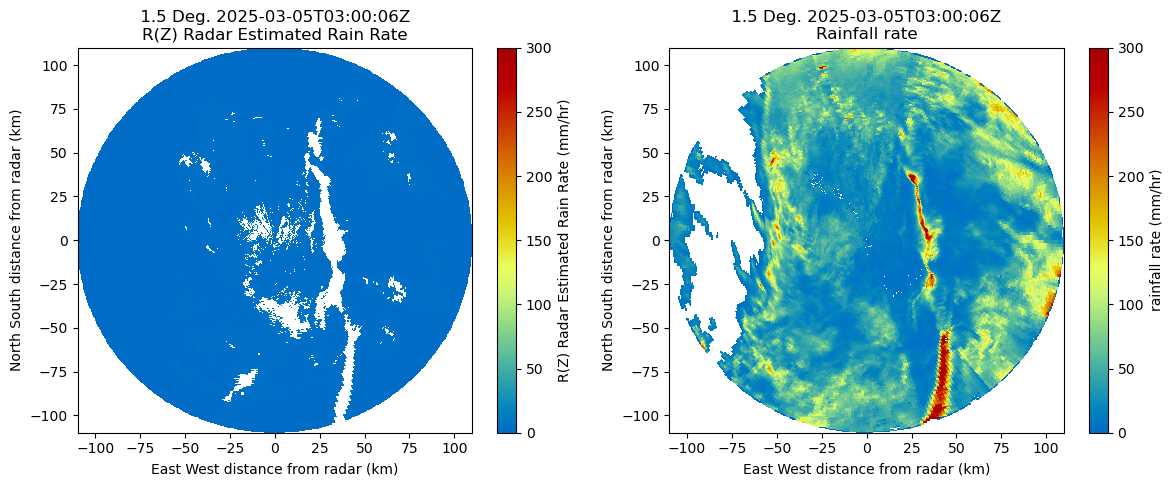

In [19]:
display = pyart.graph.RadarDisplay(radar)
# Generate matplotlib figure and axe array objects
fig, axarr = plt.subplots(1, 2, figsize=[14, 5])
plt.subplots_adjust(wspace=0.2, hspace=0.35)

# reflectivity
display.plot('rain_rate_Z',
             sweep=0,
             ax=axarr[0],
             vmin=0,
             vmax=300,
             cmap='HomeyerRainbow',
)

# differential reflectivity
display.plot("rain_rate_A",
             sweep=0,
             ax=axarr[1],
             vmin=0,
             vmax=300,
             cmap='HomeyerRainbow',)

## Create Combined Data Product

In [128]:
def add_combined_rain(radar):
    radar = reflectivity_rain(radar)
    radar = mask_kdp_rain(radar)
    combined_data = np.where(~radar.fields["rain_rate_Z"]["data"].mask, radar.fields["rain_rate_Z"]["data"], radar.fields["rain_rate_A"]["data"])
    # Combine the masks using logical OR (mask where either is masked)
    combined_mask = np.ma.mask_or(radar.fields["rain_rate_Z"]["data"].mask, radar.fields["rain_rate_A"]["data"].mask)
    
    # Merge data and apply the combined mask
    merged = np.ma.array(combined_data, mask=combined_mask)
    
    # define the dictionary structure for the rain rate data
    rain = pyart.config.get_metadata("radar_estimated_rain_rate")
    rain["long_name"] = "R(Z+A) Radar Estimated Rain Rate"
    rain["standard_name"] = "R(Z+A) Radar Estimated Rain Rate"
    rain["data"] = combined_data
    # add the field back into the radar object
    radar.add_field("rain_rate_combined", rain, replace_existing=True)
    return radar

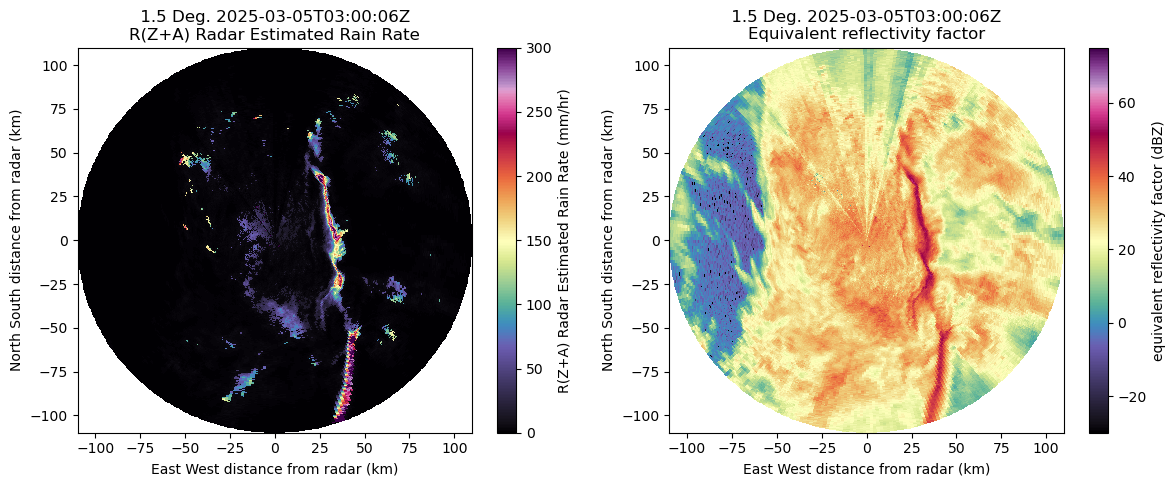

In [22]:
display = pyart.graph.RadarDisplay(radar)
# Generate matplotlib figure and axe array objects
fig, axarr = plt.subplots(1, 2, figsize=[14, 5])
plt.subplots_adjust(wspace=0.2, hspace=0.35)

# reflectivity
display.plot('rain_rate_combined', sweep=0, ax=axarr[0], cmap='ChaseSpectral', vmax=300)
# reflectivity
display.plot('reflectivity', sweep=0, ax=axarr[1], cmap='ChaseSpectral')

## Grid Using Nearest Neighbor Interpolation

### Setup a Helper Function and Configure our Grid

In [59]:
def compute_number_of_points(extent, resolution):
    """
    Create a helper function to determine number of points
    """
    return int((extent[1] - extent[0])/resolution) + 1

# Grid extents in meters
z_grid_limits = (250.,10_250.)
y_grid_limits = (-80_000.,80_000.)
x_grid_limits = (-80_000.,80_000.)

# Grid resolution in meters
grid_resolution = 500

Once we setup our interpolation, we can compute the number of points for each extent

In [60]:
x_grid_points = compute_number_of_points(x_grid_limits, grid_resolution)
y_grid_points = compute_number_of_points(y_grid_limits, grid_resolution)
z_grid_points = compute_number_of_points(z_grid_limits, grid_resolution)

print(z_grid_points,
      y_grid_points,
      x_grid_points)

21 321 321


### Create our Grid using `grid_from_radars`

In [104]:
grid = pyart.map.grid_from_radars(radar,
                                  grid_shape=(z_grid_points,
                                              y_grid_points,
                                              x_grid_points),
                                  grid_limits=(z_grid_limits,
                                               y_grid_limits,
                                               x_grid_limits),
                                  method='nearest',
                                  fields=["reflectivity",
                                          "rain_rate_A",
                                          "rain_rate_Z",
                                          "rain_rate_combined"],
                                  constant_radius=500
                                 )

## Visualize our Grid
We start by converting our grid to xarray

In [105]:
ds = grid.to_xarray()
ds

<xarray.Dataset> Size: 71MB
Dimensions:                     (time: 1, z: 21, y: 321, x: 321, nradar: 1)
Coordinates: (12/16)
  * time                        (time) object 8B 2025-03-05 03:00:06
  * z                           (z) float64 168B 250.0 750.0 ... 1.025e+04
    lat                         (y, x) float64 824kB 33.91 33.91 ... 35.35 35.35
    lon                         (y, x) float64 824kB -88.0 -87.99 ... -86.25
  * y                           (y) float64 3kB -8e+04 -7.95e+04 ... 8e+04
  * x                           (x) float64 3kB -8e+04 -7.95e+04 ... 8e+04
    ...                          ...
    origin_altitude             (time) float32 4B 12.0
    radar_altitude              (nradar) float32 4B 12.0
    radar_latitude              (nradar) float32 4B 34.63
    radar_longitude             (nradar) float32 4B -87.13
    radar_time                  (nradar) int64 8B 0
    radar_name                  (nradar) <U1 4B ''
Dimensions without coordinates: nradar
Data variables:
    reflectivity                (time, z, y, x) float32 9MB nan nan ... nan nan
    rain_rate_A                 (time, z, y, x) float64 17MB nan nan ... nan nan
    rain_rate_Z                 (time, z, y, x) float64 17MB nan nan ... nan nan
    rain_rate_combined          (time, z, y, x) float64 17MB nan nan ... nan nan
    ROI                         (time, z, y, x) float32 9MB 1.975e+03 ... 1.9...
Attributes: (12/28)
    radar_name:            
    nradar:                1
    command_line:          cmaccsapr2 -s bnf -f S3 -b 20250305.000000 -e 2025...
    process_version:       vap-cmaccsapr2-0.0-0.dev0.dirty.el8
    dod_version:           csapr2cmac-c1-1.2
    input_datastreams:     bnfcsapr2cfrS3.a1 : 1.7 : 20250305.030006\nbnfsond...
    ...                    ...
    source:                Atmospheric Radiation Measurement (ARM) program C-...
    history:               created by user rjackson on machine cirrus2.ccs.or...
    volume_number:         0
    platform_type:         fixed
    instrument_type:       radar
    primary_axis:          axis_z

In [106]:
print(f"min lat: {ds.lat.min().values} max lat: {ds.lat.max().values}")
print(f"min lon: {ds.lon.min().values} max lon: {ds.lon.max().values}")

min lat: 33.90827445523845 max lat: 35.35026397833209
min lon: -88.01516112168518 max lon: -86.25107766396387


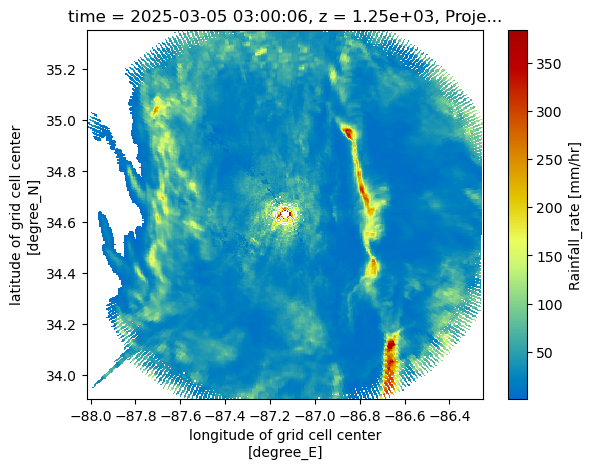

In [107]:
ds.rain_rate_A.isel(z=2).plot(x='lon',
                              y='lat',
                              cmap='HomeyerRainbow')

## Determine the Lowest Height in Each Column
We plotted the lowest level (500 m) in the plot above. It would be **more helpful** to have data from the lowest data point (lowest z) in each column (across time, latitude, and longitude)

We start first by creating a new field in our dataset, `height_expanded`, which is a four-dimensional (time, z, x, y) vertical coordinate, with nan values where we have missing snow rate values.

In [108]:
ds["height_expanded"] = (ds.z * (ds.rain_rate_combined/ds.rain_rate_combined)).fillna(10_000)

Next, we find the index of the lowest value in this column, using the `.argmin` method, looking over the column (z)

In [109]:
min_index = ds.height_expanded.argmin(dim='z',
                                      skipna=True)

Here is a plot of the lowest value height in the column for our domain:

**Notice how some values are the top of the column - 5000 m, whereas some of the values are close lowest vertical level, 500 m

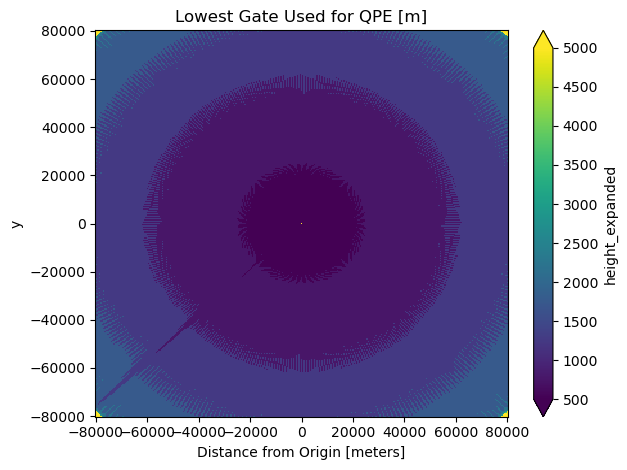

In [110]:
ds.height_expanded.isel(z=min_index).plot(vmin=500,
                                          vmax=5_000)
plt.title("Lowest Gate Used for QPE [m]")
plt.xlabel("Distance from Origin [meters]")

plt.tight_layout();

### Apply this to our snow fields
We first check for snow fields in our dataset, by using the following list comprehension line:

In [111]:
snow_fields = [var for var in list(ds.variables) if "rain" in var]
snow_fields

['rain_rate_A', 'rain_rate_Z', 'rain_rate_combined']

Next, we subset our dataset for only these fields and select our lowest z value (using the index we built before)

In [112]:
subset_ds = ds[snow_fields].isel(z=min_index)

### Visualize our closest-to-ground snow value
Now that we have the lowest vertical level in each column, let's plot our revised maps, which only have dimensions:
- time
- latitude
- longitude

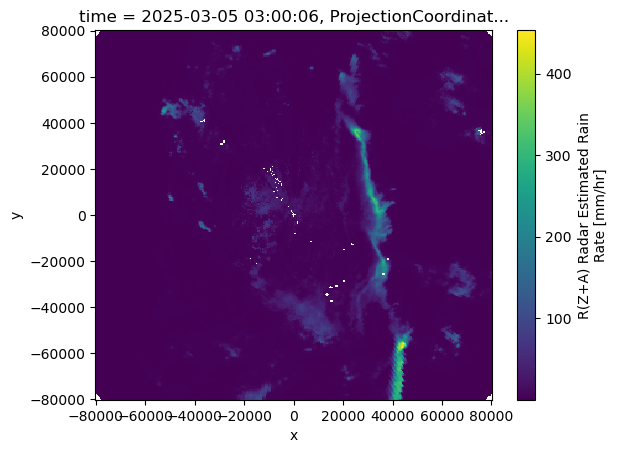

In [120]:
subset_ds["rain_rate_combined"].where(subset_ds["rain_rate_combined"] < 1000, np.nan).plot()

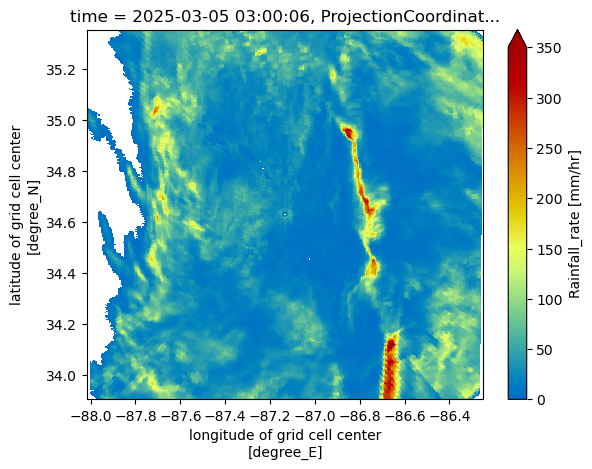

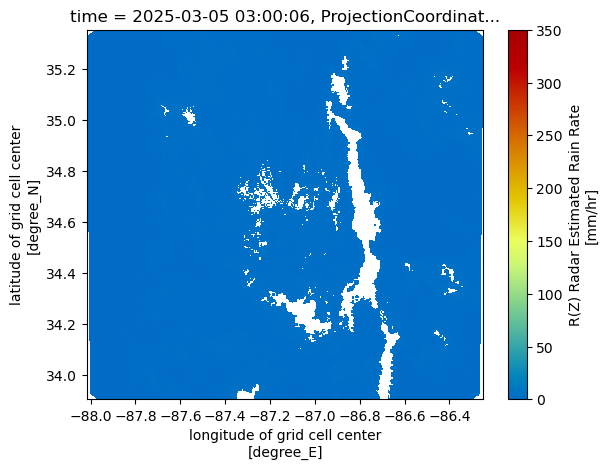

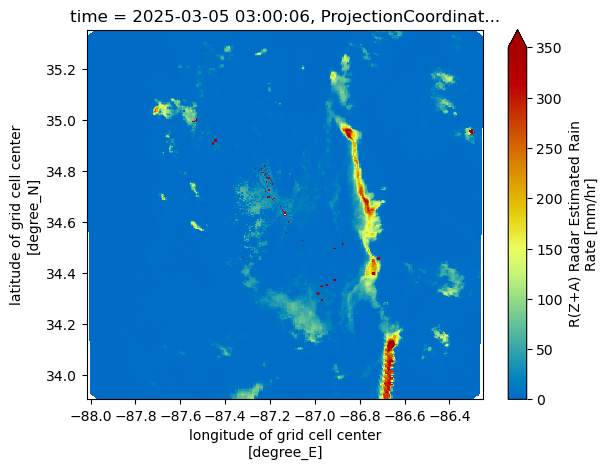

In [113]:
for snow_field in snow_fields:
    subset_ds[snow_field].plot(x='lon',
                               y='lat',
                               cmap='HomeyerRainbow',
                               vmin=0,
                               vmax=350)
    plt.show()
    plt.close()

## Wrap this Up into a Function
Now that we have the full pipeline, let's wrap this into a function!

In [132]:
def grid_radar(file,
               # Grid extents in meters
               z_grid_limits = (250.,10_250.),
               y_grid_limits = (-80_000.,80_000.),
               x_grid_limits = (-80_000.,80_000.),
               # Grid resolution in meters
               grid_resolution = 500
               ):
    """
    Grid the radar using some provided parameters
    """
    
    radar = pyart.io.read(file)

    # Add R(Z) field, mask R(A), add combined rain field
    radar = add_combined_rain(radar)
    
    x_grid_points = compute_number_of_points(x_grid_limits, grid_resolution)
    y_grid_points = compute_number_of_points(y_grid_limits, grid_resolution)
    z_grid_points = compute_number_of_points(z_grid_limits, grid_resolution)
    
    grid = pyart.map.grid_from_radars(radar,
                                      grid_shape=(z_grid_points,
                                                  y_grid_points,
                                                  x_grid_points),
                                      grid_limits=(z_grid_limits,
                                                   y_grid_limits,
                                                   x_grid_limits),
                                      fields=["reflectivity",
                                              "rain_rate_A",
                                              "rain_rate_Z",
                                              "rain_rate_combined"],
                                      constant_radius=500,
                                      method='nearest'
                                     )
    return grid.to_xarray()

def subset_lowest_vertical_level(ds, additional_fields=["reflectivity"]):
    """
    Filter the dataset based on the lowest vertical level
    """
    rain_fields = [var for var in list(ds.variables) if "rain" in var] + additional_fields
    
    # Create a new 4-d height field
    ds["height_expanded"] = (ds.z * (ds[rain_fields[0]]/ds[rain_fields[0]])).fillna(5_000)
    
    # Find the minimum height index
    min_index = ds.height_expanded.argmin(dim='z',
                                          skipna=True)
    
    # Subset our snow fields based on this new index
    subset_ds = ds[rain_fields].isel(z=min_index)

    for field in rain_fields:
        subset_ds[field].where(subset_ds[field] < 1000, np.nan)
    
    return subset_ds

## Loop Through and Apply this Workflow
Now that we have our helper functions, we can apply our workflow to each file.

In [141]:
for file in cmac_files:
    ds = grid_radar(file)
    out_ds = subset_lowest_vertical_level(ds)
    
    # Create an output path
    out_path = f"{Path(file).stem.replace('cmac', 'squire')}.nc"
    out_ds.to_netcdf(f"data/squire/{out_path}")
    print("Finished writing:", out_path)

Finished writing: bnfcsapr2squireS3.c1.20250305.030006.nc
